In [171]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualization

import tensorflow as tf # Deep Learning
import tensorflow_hub as hub # Pre-trained models
 

# Data Preprocessing

In [172]:
df = pd.read_csv('Twitter_Data.csv') # Read the data only with the columns that we need
df.head() # Show the first 5 rows of the data
df2 = pd.read_csv('Reddit_Data.csv')
df2 = df2.rename(columns={'clean_comment': 'clean_text'})
df = pd.concat([df, df2])

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200229 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  200125 non-null  object 
 1   category    200222 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.6+ MB


As we can see, there are missing values in the data. We will drop the missing values. Because it is a small amount of data.

In [174]:
df.dropna(inplace=True) # Drop the missing values

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200118 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  200118 non-null  object 
 1   category    200118 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.6+ MB


In [176]:
df['category'].unique()

array([-1.,  0.,  1.])

Now need to convert the labels to numerical values. We will convert the labels to 0, 1, 2. 0 for Negative, 1 for Neutral, 2 for Positive.

In [177]:
df['category'] = df['category'].apply(lambda x: 0 if x == -1 else (1 if x == 0 else 2)) # Convert the labels to numerical values

In [178]:
df['category'].unique()
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2


Check if data is balanced

In [179]:
len(df[df['category'] == 0]) , len(df[df['category'] == 1]) , len(df[df['category'] == 2]) # Count the number of each label

(43786, 68253, 88079)

Data is balanced. Now we can convert the data to a tensorflow dataset.

In [180]:
# function that converts a panda dataframe to a tensorflow dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=1024): # Function to convert a dataframe to a dataset
    df = dataframe.copy() # avoid modifying the original dataframe
    labels = df.pop("category") # Remove the label column from the dataframe
    df = df["clean_text"] # Keep only the description column
    ds = tf.data.Dataset.from_tensor_slices((df, labels)) # Create a tensorflow dataset
    if shuffle: # Shuffle the dataset if needed
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)  # Batch the dataset
    ds = ds.prefetch(tf.data.AUTOTUNE) # automatically tune the number of batches to prefetch based on the current runtime conditions
    return ds

In [181]:
train, val , test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))]) # Split the data into train, validation and test sets with 80%, 10% and 10% of the data 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [182]:
train_data = df_to_dataset(train) # Convert the train dataframe to a tensorflow dataset
val_data = df_to_dataset(val) # Convert the validation dataframe to a tensorflow dataset
test_data = df_to_dataset(test) # Convert the test dataframe to a tensorflow dataset

# Model

In [183]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2" # Load the embedding model
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True) # Create a keras layer with the embedding model

In [184]:
model = tf.keras.Sequential() # Create a sequential model
model.add(hub_layer) # Add the pre-trained layer

# Assuming the output of hub_layer is a flat vector. This is just a conceptual example.
# In practice, CNNs need sequence or matrix inputs.
#model.add(tf.keras.layers.Reshape((50, 1)))  # Reshape for CNN, if necessary
#model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))  # Example CNN layer
#model.add(tf.keras.layers.GlobalMaxPooling1D())  # Pooling layer to reduce dimensionality


model.add(tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Add a hidden layer with 16 neurons
model.add(tf.keras.layers.Dense(3, activation='softmax')) 

In [185]:
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # gradient descent algorithm
    loss =  tf.keras.losses.SparseCategoricalCrossentropy(), # loss function
    metrics = ['accuracy']
)

In [186]:
model.evaluate(train_data) # Evaluate the model on the test data

157/157 [==============================] - 1s 4ms/step - loss: 1.3736 - accuracy: 0.2789


[1.3736134767532349, 0.2789486050605774]

In [187]:
model.evaluate(val_data) # Evaluate the model on the validation data

20/20 [==============================] - 0s 4ms/step - loss: 1.3715 - accuracy: 0.2840


[1.3715438842773438, 0.2840295732021332]

In [188]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 10
)

Epoch 1/10
157/157 [==============================] - 26s 163ms/step - loss: 1.0680 - accuracy: 0.5642 - val_loss: 0.7901 - val_accuracy: 0.7437
Epoch 2/10
157/157 [==============================] - 26s 163ms/step - loss: 0.5813 - accuracy: 0.8556 - val_loss: 0.4703 - val_accuracy: 0.8954
Epoch 3/10
157/157 [==============================] - 26s 163ms/step - loss: 0.3668 - accuracy: 0.9344 - val_loss: 0.3679 - val_accuracy: 0.9239
Epoch 4/10
157/157 [==============================] - 27s 170ms/step - loss: 0.2837 - accuracy: 0.9538 - val_loss: 0.3215 - val_accuracy: 0.9307
Epoch 5/10
157/157 [==============================] - 27s 169ms/step - loss: 0.2395 - accuracy: 0.9622 - val_loss: 0.2946 - val_accuracy: 0.9365
Epoch 6/10
157/157 [==============================] - 26s 164ms/step - loss: 0.2110 - accuracy: 0.9670 - val_loss: 0.2798 - val_accuracy: 0.9360
Epoch 7/10
157/157 [==============================] - 26s 166ms/step - loss: 0.1907 - accuracy: 0.9702 - val_loss: 0.2701 - val_ac

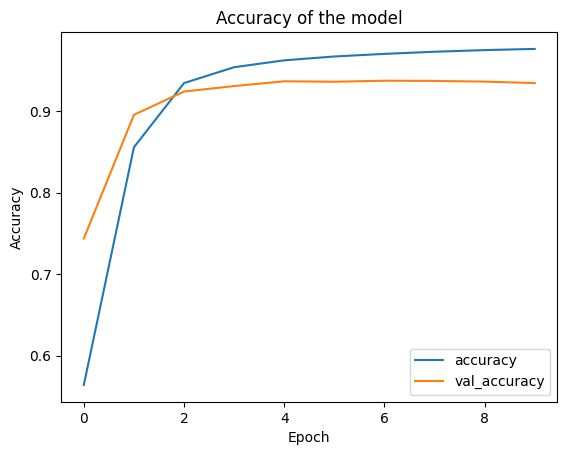

In [189]:
plt.plot(history.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

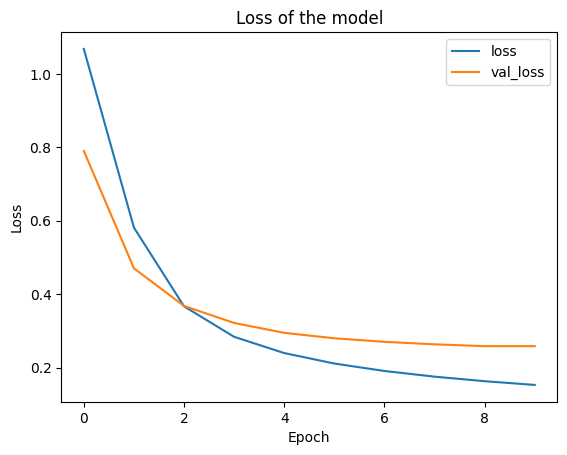

In [190]:
plt.plot(history.history['loss'], label='loss') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_loss'], label = 'val_loss') # Plot the accuracy of the model on the validation data
plt.title('Loss of the model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [191]:
model.evaluate(test_data) # Evaluate the model on the test data

20/20 [==============================] - 0s 22ms/step - loss: 0.2741 - accuracy: 0.9312


[0.2740967869758606, 0.9312412738800049]

In [192]:
def predict_sentiment(model, text):
    # Convert the text to a pandas DataFrame
    df = pd.DataFrame([text], columns=['Tweet'])

    # Convert the DataFrame to a tensorflow dataset
    ds = tf.data.Dataset.from_tensor_slices(df["Tweet"]).batch(1)

    # Use the model to predict the sentiment
    prediction = model.predict(ds)

    # Get the index of the maximum value (this will be the predicted label)
    predicted_label = np.argmax(prediction)

    # Map the numerical label back to the original label
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = sentiment_map[predicted_label]

    # Print the predicted sentiment
    print(f"{text} is {predicted_sentiment}")

In [193]:
predict_sentiment(model, "I am Gilad Fisher") 
predict_sentiment(model, "I am Barak Finkel")
predict_sentiment(model, "I am Nikita Breslavsky")
predict_sentiment(model, "I hate Nikita Breslavsky")
predict_sentiment(model, "I love Nikita Breslavsky")
predict_sentiment(model, "I love to kill people")
predict_sentiment(model, "I dont love myself")

1/1 [==============================] - 0s 47ms/step
I am Gilad Fisher is Neutral
1/1 [==============================] - 0s 25ms/step
I am Barak Finkel is Neutral
1/1 [==============================] - 0s 24ms/step
I am Nikita Breslavsky is Neutral
1/1 [==============================] - 0s 24ms/step
I hate Nikita Breslavsky is Negative
1/1 [==============================] - 0s 23ms/step
I love Nikita Breslavsky is Positive
1/1 [==============================] - 0s 23ms/step
I love to kill people is Positive
1/1 [==============================] - 0s 24ms/step
I dont love myself is Positive


In [194]:
# LSTM MODEL
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [195]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'modi', 'and', 'for', 'you', 'that', 'this',
       'are', 'not', 'will', 'india', 'with', 'have', 'but', 'has',
       'they', 'all', 'was'], dtype='<U15')

In [201]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [206]:
model2.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # gradient descent algorithm
    loss =  tf.keras.losses.SparseCategoricalCrossentropy(), # loss function
    metrics = ['accuracy']
)

In [207]:
model2.evaluate(train_data) # Evaluate the model on the test data

157/157 [==============================] - 94s 588ms/step - loss: 1.0982 - accuracy: 0.3641


[1.0982247591018677, 0.3641235828399658]

In [208]:
model2.evaluate(val_data) # Evaluate the model on the validation data

20/20 [==============================] - 11s 518ms/step - loss: 1.0982 - accuracy: 0.3627


[1.0981894731521606, 0.3627323508262634]

In [209]:
model2.fit(
    train_data,
    validation_data = val_data,
    epochs = 5
)

Epoch 1/5
157/157 [==============================] - 283s 2s/step - loss: 0.8175 - accuracy: 0.6394 - val_loss: 0.5037 - val_accuracy: 0.8313
Epoch 2/5
157/157 [==============================] - 282s 2s/step - loss: 0.4275 - accuracy: 0.8732 - val_loss: 0.3617 - val_accuracy: 0.8925
Epoch 3/5
157/157 [==============================] - 282s 2s/step - loss: 0.3732 - accuracy: 0.8929 - val_loss: 0.3510 - val_accuracy: 0.8942
Epoch 4/5
157/157 [==============================] - 276s 2s/step - loss: 0.3607 - accuracy: 0.8960 - val_loss: 0.3479 - val_accuracy: 0.8946
Epoch 5/5
157/157 [==============================] - 278s 2s/step - loss: 0.3546 - accuracy: 0.8968 - val_loss: 0.3431 - val_accuracy: 0.8945


In [210]:
model2.evaluate(test_data) # Evaluate the model on the test data

20/20 [==============================] - 13s 662ms/step - loss: 0.3402 - accuracy: 0.8972


[0.34024637937545776, 0.8972116708755493]

In [211]:
predict_sentiment(model, "I am Gilad Fisher")
predict_sentiment(model, "I am Barak Finkel")
predict_sentiment(model, "I am Nikita Breslavsky")
predict_sentiment(model, "I hate Nikita Breslavsky")
predict_sentiment(model, "I love Nikita Breslavsky")
predict_sentiment(model, "I love to kill people")
predict_sentiment(model, "I dont love myself")

1/1 [==============================] - 0s 75ms/step
I am Gilad Fisher is Neutral
1/1 [==============================] - 0s 25ms/step
I am Barak Finkel is Neutral
1/1 [==============================] - 0s 23ms/step
I am Nikita Breslavsky is Neutral
1/1 [==============================] - 0s 24ms/step
I hate Nikita Breslavsky is Negative
1/1 [==============================] - 0s 21ms/step
I love Nikita Breslavsky is Positive
1/1 [==============================] - 0s 23ms/step
I love to kill people is Positive
1/1 [==============================] - 0s 23ms/step
I dont love myself is Positive
